## Load some data

In [1]:
import jax
jax.config.update("jax_enable_x64", True)


import matplotlib.pyplot as plt
from matplotlib import colormaps, colors

%matplotlib inline
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 120

inferno = colormaps["inferno"]
seismic = colormaps["seismic"]
twilight = colormaps["twilight"]

inferno.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)
twilight.set_bad("k", 0.5)

In [2]:
from amigo.files import get_files
from amigo.files import summarise_files

# Bind file path, type and exposure type
file_fn = lambda **kwargs: get_files(
    ["/Users/louis/Data/JWST/amigo_data/CAL04481/calslope/",],
    "calslope",
    EXP_TYPE="NIS_AMI",
    IS_PSF=[True],  # Calibrators
    EXPOSURE=[str(i + 1) for i in range(1)],  # Which sub-pixel position
    **kwargs,
)

files = [] + file_fn(FILTER="F380M") + file_fn(FILTER="F430M") + file_fn(FILTER="F480M")
# files = files[:1]

print(f"\n{len(files)}")
summarise_files(
    files,
    ["TARGPROP", "FILTER", "NINTS", "NGROUPS", "OBSERVTN", "NCHUNKS", "EXPOSURE"],
)

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-063 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-065
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf



3
  TARGPROP: HD-41094
  FILTER: F430M, F380M, F480M
  NINTS: 760, 905, 1060
  NGROUPS: 11, 20, 30
  OBSERVTN: 001
  NCHUNKS: 1
  EXPOSURE: 1


In [3]:
import jax.numpy as np

for file in files:
    file["SCI"].data[:, :, -1:] = np.nan
    file["SCI_VAR"].data[:, :, -1:] = np.nan
    file["ZPOINT"].data[:, -1:] = np.nan
    file["ZPOINT_VAR"].data[:, -1:] = np.nan

    file["SCI"].data[:, 41:43, 1] = np.nan

## Construct and load a model

In [4]:
import jax.numpy as np
from amigo.core_models import AmigoModel
from amigo.optical_models import AMIOptics
from amigo.detector_models import LinearDetectorModel
from amigo.read_models import ReadModel
from amigo.ramp_models import SimpleRamp, PolyNonLin
from amigo.files import get_exposures, initialise_params
from amigo.model_fits import PointFit

oversample = 4
optics = AMIOptics(radial_orders=4, oversize=1.1, oversample=oversample)
detector = LinearDetectorModel(oversample=oversample)
ramp_model = PolyNonLin(oversample=oversample)
read_model = ReadModel()

# Prep the model
fit = PointFit()
exposures = get_exposures(files, fit)
params = initialise_params(exposures, optics, fit_one_on_fs=False)

# Add the binary parameters
model = AmigoModel(
    files, params, optics=optics, detector=detector, ramp=ramp_model, read=read_model
)

In [5]:
from zodiax.experimental import deserialise
from amigo.files import repopulate

path = "files/simple_poly_fit"
model = repopulate(model, deserialise(f"{path}/reg_history.zdx"))
model = repopulate(model, deserialise(f"{path}/batch_history.zdx"))

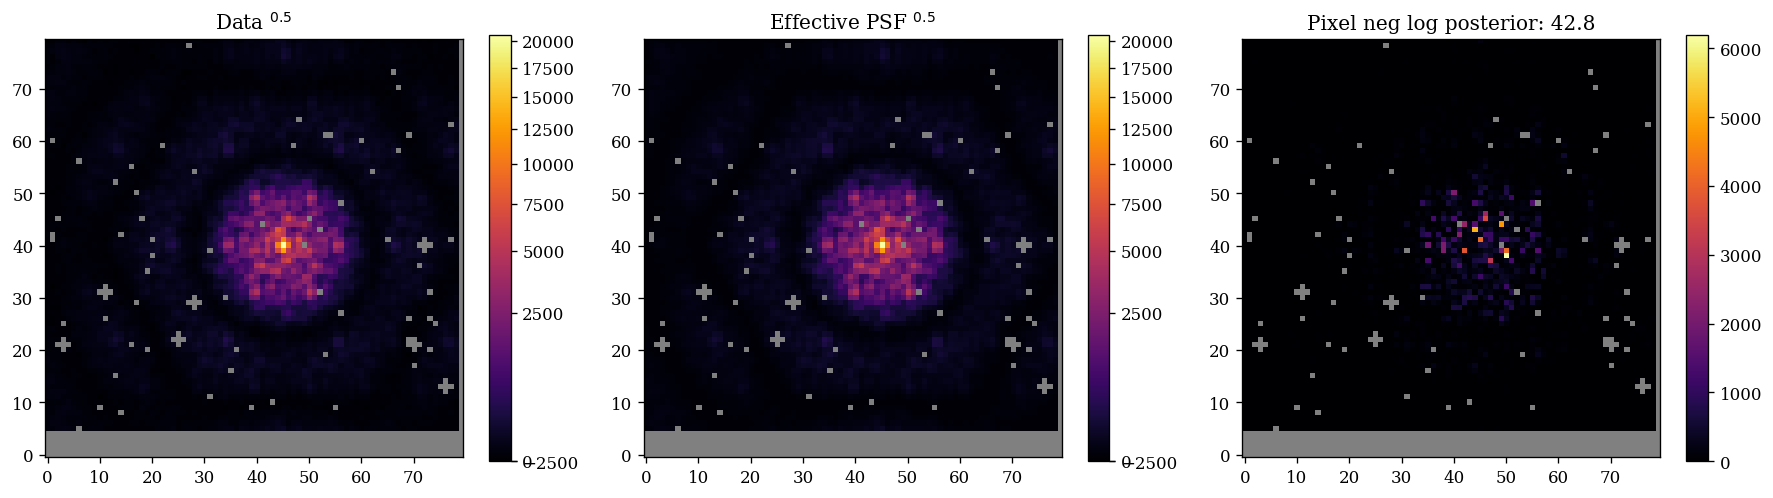

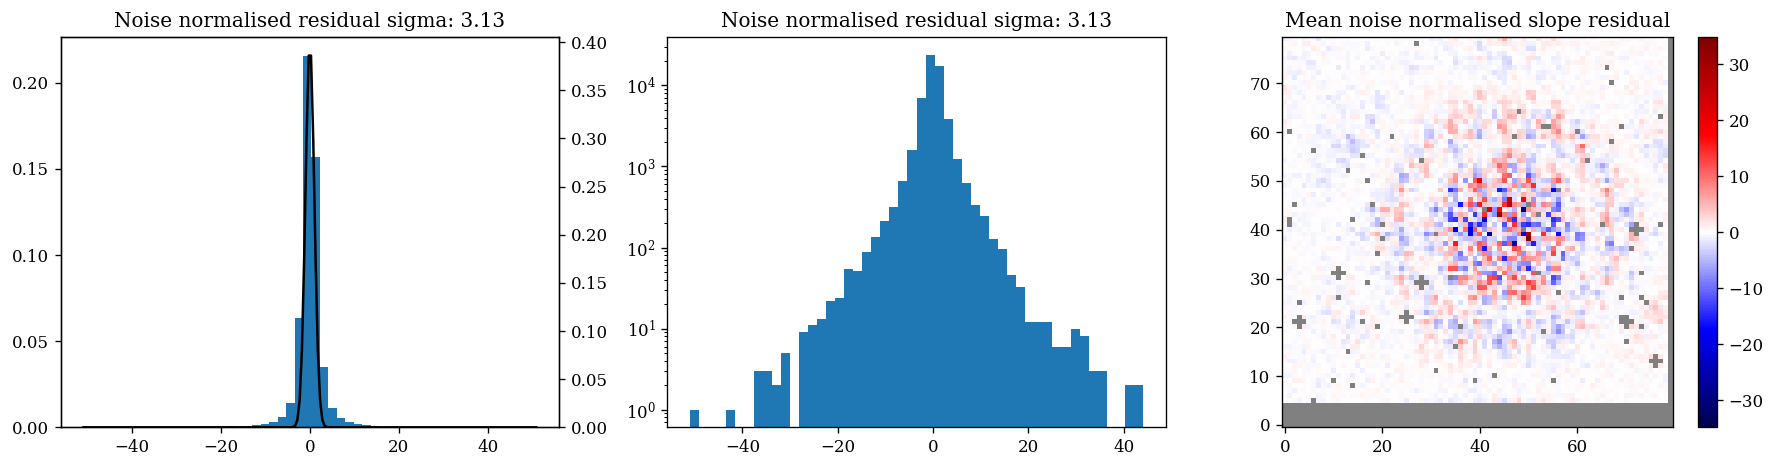

In [6]:
from amigo.plotting import summarise_fit

for exp in exposures[:1]:
    summarise_fit(
        exp,
        model,
        residuals=True,
        histograms=True,
    )

## Model and look at splodges, mask 

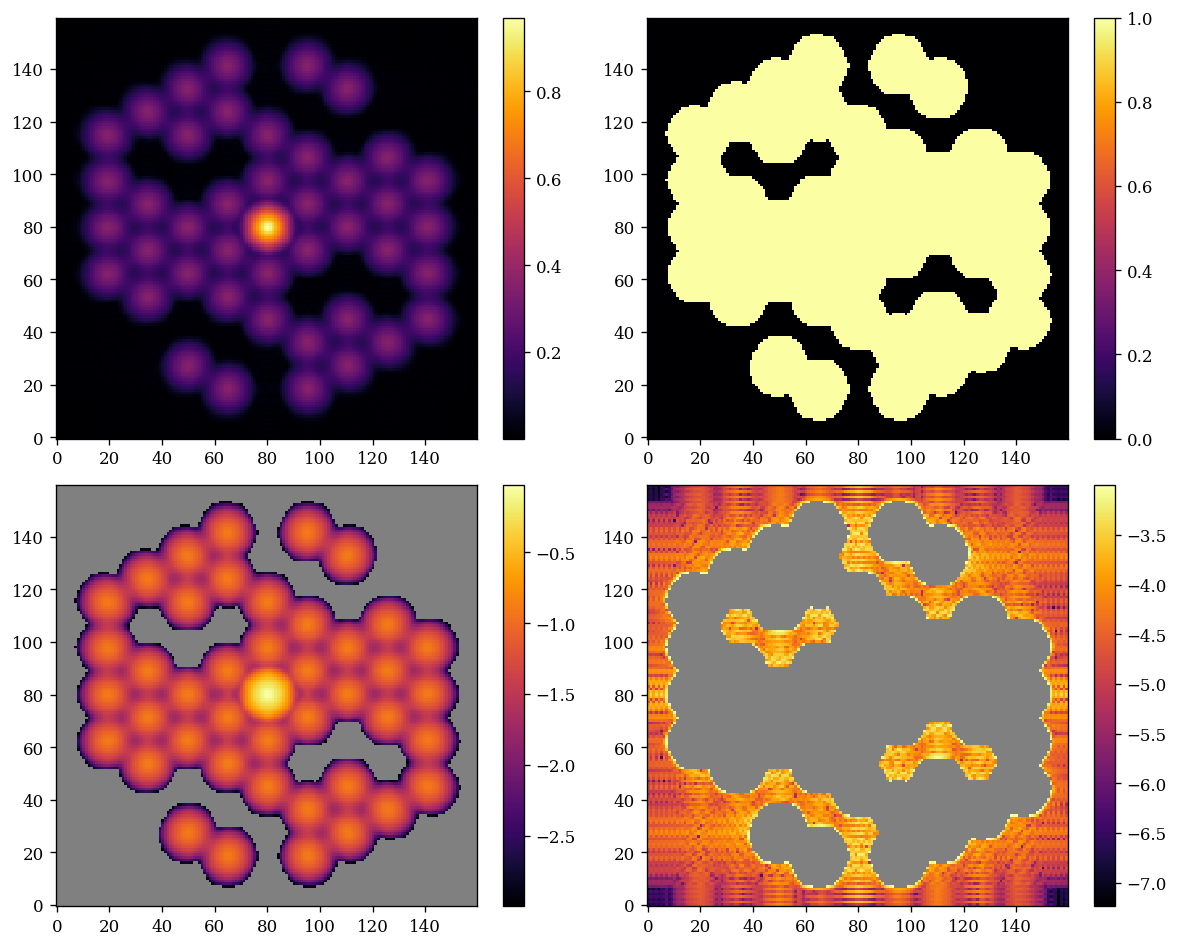

In [7]:
from jax import vmap
import interpax as ipx
import dLux.utils as dlu
from amigo.interferometry import to_uv, from_uv

# Create the splodges
uv_pad = 2
exp = exposures[0]
psf = fit.model_wfs(model, exp).psf.sum(0)
padded = dlu.resize(psf, uv_pad * len(psf))
npix_in = padded.shape[-1]

# Crop the splodges
npix_out = 160
full_splodges = to_uv(padded)
splodges = np.abs(dlu.resize(full_splodges, npix_out))

# Mask outside the OTF region - Shouldn't need to be done in practice
mask = splodges > 1e-3
inner = np.where(mask, splodges, np.nan)
outer = np.where(~mask, splodges, np.nan)

plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.imshow(splodges ** 0.5)
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(mask)
plt.colorbar()

plt.subplot(2, 2, 3)
plt.imshow(np.log10(inner), cmap=inferno)
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(np.log10(outer), cmap=inferno)
plt.colorbar()

plt.tight_layout()
plt.show()

## Find control points (knots) to match visibility coordinates

160 control points


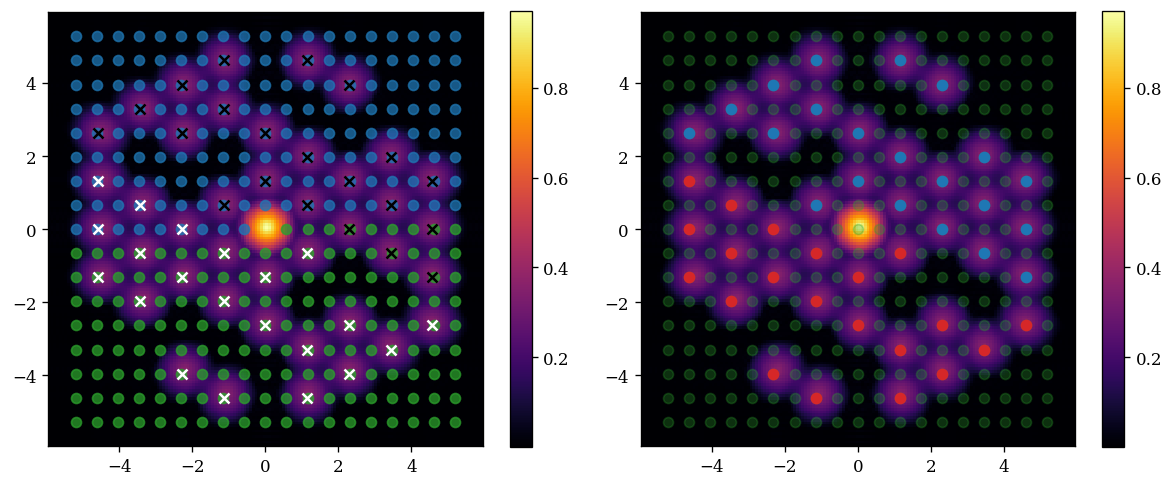

In [8]:
import jax.random as jr
from amigo.interferometry import get_baselines_and_inds, osamp_freqs

# Make interpolator of the visibilities on the OTF coordinates
cen_holes = optics.holes - optics.holes.mean(0)[None, :]
hbls, inds = get_baselines_and_inds(cen_holes)
bls = np.concatenate([np.zeros((1, 2)), hbls, -hbls]).T

# Define number of control points and add padding to control outer behaviour
x_pts, y_pts = 17, 15
dx, dy = 2 / (x_pts - 1), 2 / (y_pts - 1)
xs = bls.max() * np.linspace(-(1 + dx), 1 + dx, x_pts + 2)
ys = bls.max() * np.linspace(-(1 + dy), 1 + dy, y_pts + 2)
x_pts, y_pts = len(xs), len(ys)

# Define visibility coords
wavels, weights = model.filters[exp.filter]
lam = ((wavels * weights).sum() / weights.sum()).mean()
dx = dlu.arcsec2rad(optics.psf_pixel_scale) / (optics.oversample * lam)

crop_to = lambda arr, npix: arr[(len(arr) - npix) // 2 : (len(arr) + npix) // 2]
u_coords = crop_to(osamp_freqs(full_splodges.shape[-1], dx), npix_out)

def nearest_fn(pt, coords):
    dist = np.hypot(*(coords - pt[:, None, None]))
    return dist == dist.min()

knots = np.array(np.meshgrid(xs, ys))
is_near = vmap(nearest_fn, (0, None))(hbls, knots)
bls_inds = np.where(np.sum(is_near.astype(int), 0))
bls_pts = knots[:, *bls_inds]

coords = np.array(np.meshgrid(xs, ys))
flat_knots = knots.reshape(2, -1).T
flat_knots = np.round(flat_knots, decimals=3)

# Get non redundant set of index conjugate pairs
# This works if the input coordinate set it paraxial
base_inds = np.arange(len(xs) * len(ys))
conj_inds = np.array([base_inds, base_inds[::-1]]).T
conj_inds = conj_inds[: len(conj_inds) // 2]
print(f"{len(conj_inds) - 1} control points")

xs_in = flat_knots[:, 0][conj_inds[:, 0]]
ys_in = flat_knots[:, 1][conj_inds[:, 1]]

plt.figure(figsize=(15, 4))
ext = u_coords.max()

plt.subplot(1, 3, 1)
plt.scatter(xs_in, ys_in, c="tab:blue", alpha=0.75)
plt.scatter(-xs_in, -ys_in, c="tab:green", alpha=0.75)
plt.scatter(hbls[:, 0], hbls[:, 1], marker="x", c="k")
plt.scatter(-hbls[:, 0], -hbls[:, 1], marker="x", c="w")
plt.imshow(splodges**0.5, extent=(-ext, ext, -ext, ext), cmap=inferno)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.scatter(*np.meshgrid(xs, ys), alpha=0.3, c="tab:green")
plt.scatter(*bls_pts, c="tab:blue")
plt.scatter(*-bls_pts, c="tab:red")
plt.imshow(splodges**0.5, extent=(-ext, ext, -ext, ext), cmap=inferno)
plt.colorbar()

plt.tight_layout()
plt.show()

## Calculate a conjugated visibility map

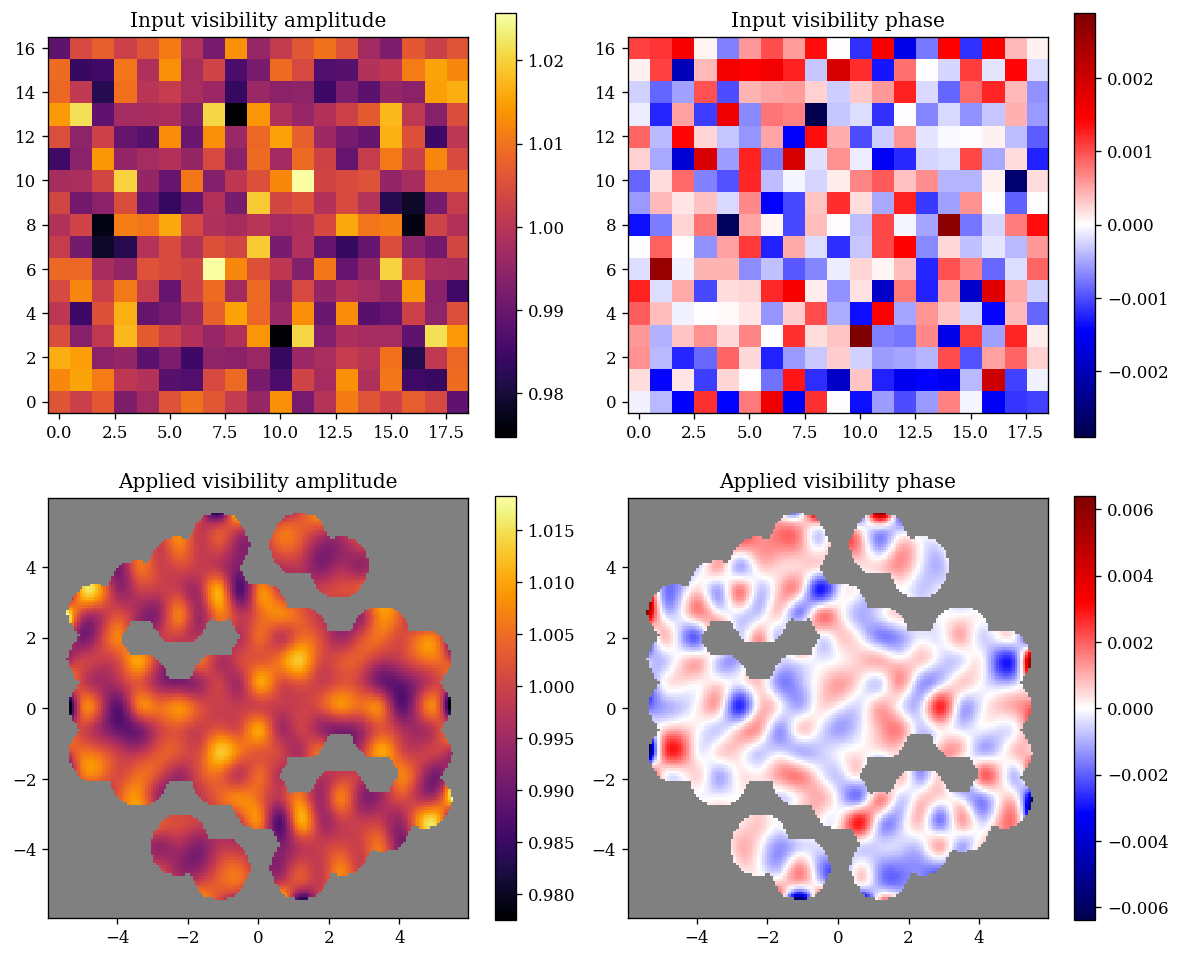

In [9]:
# Random vis values
amp_points = 1 + 1e-2 * jr.normal(jr.PRNGKey(0), (y_pts, x_pts))
pha_points = 1e-3 * jr.normal(jr.PRNGKey(1), (y_pts, x_pts))

# # Sine wave vis values
# sine_xs = 0.1 * np.linspace(-np.pi, np.pi, len(xs))# - np.pi/2
# sine_ys = 0.1 * np.linspace(-np.pi, np.pi, len(ys))
# amp_points = 1 + (0.5 * np.sin(np.meshgrid(sine_xs, sine_ys)[1]))
# pha_points = 0.5 * np.sin(np.meshgrid(sine_xs, sine_ys)[1])

# # Uniform vis values
# amp_points = np.ones_like(amp_points)
# pha_points = np.zeros_like(pha_points)

# Construct input vis map
vis = amp_points * np.exp(1j * pha_points)
flat_vis = vis.reshape(-1)

# Apply conjugate
inds = np.arange(len(flat_vis) // 2)
flat_vis = flat_vis.at[-(inds + 1)].set(flat_vis[inds].conj())
flat_vis = flat_vis.at[len(inds)].set(1 * np.exp(1j * 0))
vis_pts = flat_vis.reshape(vis.shape)

# Bind indexes to interpolation function
# Note the x and y are flipped here since image indexing is (y, x)
interp_fn = lambda xpts, ypts, f: ipx.interp2d(
    ypts.flatten(), xpts.flatten(), ys, xs, f, method="cubic2", extrap=True
).reshape(xpts.shape)

# Get the applied visibilities map
uv_coords = np.meshgrid(u_coords, u_coords)
amp_map = np.maximum(interp_fn(*uv_coords, np.abs(vis_pts)), 0)
phase_map = interp_fn(*uv_coords, np.angle(vis_pts))
vis_map = amp_map * np.exp(1j * phase_map)


plt.figure(figsize=(10, 12))

plt.subplot(3, 2, 1)
plt.title("Input visibility amplitude")
plt.imshow(np.abs(vis_pts))
plt.colorbar()

plt.subplot(3, 2, 2)
plt.title("Input visibility phase")
v = np.abs(np.angle(vis_pts)).max()
plt.imshow(np.angle(vis_pts), cmap=seismic, vmin=-v, vmax=v)
plt.colorbar()

plt.subplot(3, 2, 3)
plt.title("Applied visibility amplitude")
plt.imshow(
    np.where(mask, np.abs(vis_map), np.nan) ** 0.5,
    cmap=inferno,
    extent=(-ext, ext, -ext, ext),
)
plt.colorbar()

plt.subplot(3, 2, 4)
plt.title("Applied visibility phase")
v = np.nanmax(np.abs(np.where(mask, np.angle(vis_map), np.nan)))
plt.imshow(
    np.where(mask, np.angle(vis_map), np.nan),
    cmap=seismic,
    vmin=-v,
    vmax=v,
    extent=(-ext, ext, -ext, ext),
)
plt.colorbar()
plt.tight_layout()
plt.show()

## Apply to the psf

1.0067272637340102e-08


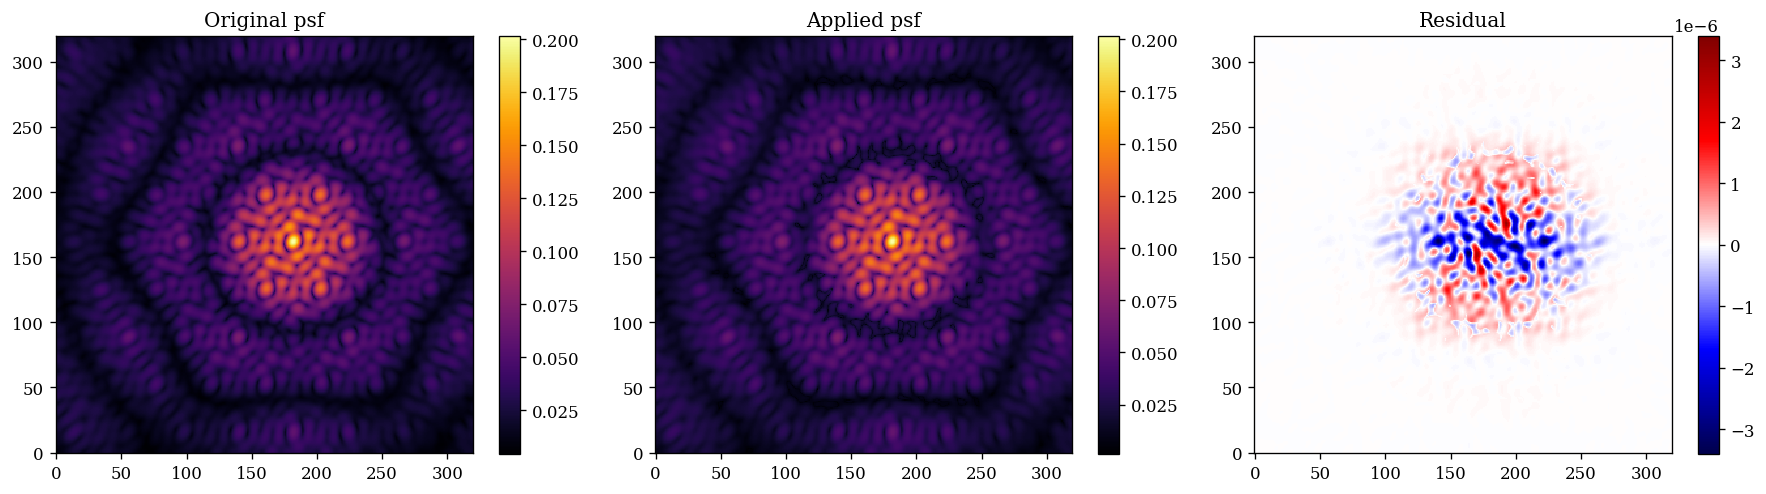

In [10]:
# Get original psf
full_vis_map = dlu.resize(vis_map, padded.shape[0])

applied = np.where(np.abs(full_splodges) > 1e-3, full_splodges * full_vis_map, full_splodges)
full_psf = np.abs(from_uv(applied))
applied_psf = dlu.resize(full_psf, psf.shape[0])

print(np.sum(np.square(applied_psf - psf)))

# break
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.title("Original psf")
plt.imshow(psf**0.25, cmap=inferno)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Applied psf")
plt.imshow(applied_psf**0.25)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Residual")
res = psf - applied_psf
v = np.abs(res).max()
plt.imshow(res, cmap=seismic, vmin=-v, vmax=v)
plt.colorbar()

plt.tight_layout()
plt.show()

## Build into the Amigo framework

In [11]:
import equinox as eqx
import zodiax as zdx
import jax.tree_util as jtu
from amigo.model_fits import PointFit

def conjugate_vis(vis):
    # Need to divide by two since visibilities are complex numbers
    if (vis.size // 2) % 2 == 0:
        raise ValueError("Vis shape must be odd")
    inds = np.arange(vis.size // 2)
    flat_vis = vis.reshape(-1)
    flat_vis = flat_vis.at[-(inds + 1)].set(flat_vis[inds].conj())
    flat_vis = flat_vis.at[len(inds)].set(1 * np.exp(1j * 0))
    return flat_vis.reshape(vis.shape)


def get_mean_wavelength(wavels, weights):
    """Get the spectrally weighted mean wavelength"""
    return ((wavels * weights).sum() / weights.sum()).mean()


def get_uv_coords(wavel, pixel_scale, crop_size):
    """Assumes pixel scale is in radians"""
    dx = pixel_scale / wavel
    crop_to = lambda arr, npix: arr[(len(arr) - npix) // 2 : (len(arr) + npix) // 2]
    u_coords = crop_to(osamp_freqs(len(padded), dx), crop_size)
    uv_coords = np.meshgrid(u_coords, u_coords)
    return uv_coords


def sample_spline(image, knots, sample_coords):
    xs, ys = knots
    xpts, ypts = jtu.tree_map(lambda x: x.flatten(), sample_coords)

    # NOTE: Extrapolation is used since the outer edges get cut with a hard edge
    # and there are some pixels in the support outside the edge points
    return ipx.interp2d(
        ypts, xpts, ys[:, 0], xs[0], image, method="cubic2", extrap=True
    ).reshape(sample_coords[0].shape)


class SplineVis(zdx.Base):
    """knots is (x, y) indexed."""

    bls: np.ndarray
    bls_inds: np.ndarray
    hole_inds: np.ndarray
    knots: np.ndarray

    def __init__(self, optics):

        # Get the baseline coordinates OTF coordinates
        cen_holes = optics.holes - optics.holes.mean(0)[None, :]
        bls, hole_inds = get_baselines_and_inds(cen_holes)
        self.bls = bls
        self.hole_inds = hole_inds

        # Define number of control points and add padding to control outer behaviour
        x_pts, y_pts = 17, 15
        dx, dy = 2 / (x_pts - 1), 2 / (y_pts - 1)
        xs = bls.max() * np.linspace(-(1 + dx), 1 + dx, x_pts + 2)
        ys = bls.max() * np.linspace(-(1 + dy), 1 + dy, y_pts + 2)
        self.knots = np.array(np.meshgrid(xs, ys))

        def nearest_fn(pt, coords):
            dist = np.hypot(*(coords - pt[:, None, None]))
            return dist == dist.min()

        is_near = vmap(nearest_fn, (0, None))(bls, self.knots)
        self.bls_inds = np.where(np.sum(is_near.astype(int), 0))


class SplineVisFit(PointFit):
    uv_pad: int = eqx.field(static=True)
    crop_size: int = eqx.field(static=True)
    joint_fit: bool = eqx.field(static=True)

    def __init__(self, uv_pad=2, crop_size=160, joint_fit=True):
        self.uv_pad = int(uv_pad)
        self.crop_size = int(crop_size)
        self.joint_fit = bool(joint_fit)

    def get_key(self, exposure, param):

        # Return the per exposure key if not joint fitting
        if not self.joint_fit:
            if param in ["amplitudes", "phases"]:
                return exposure.key

        return super().get_key(exposure, param)

    def get_uv_coords(self, model, exposure):
        lam = get_mean_wavelength(*self.get_spectra(model, exposure))
        pscale = dlu.arcsec2rad(model.optics.psf_pixel_scale / model.optics.oversample)
        return get_uv_coords(lam, pscale, self.crop_size)

    def get_vis_pts(self, model, exposure):
        amp_points = model.amplitudes[exposure.get_key("amplitudes")]
        pha_points = model.phases[exposure.get_key("phases")]
        return conjugate_vis(amp_points * np.exp(1j * pha_points))

    def get_vis_map(self, model, exposure):
        # Get the inputs
        vis_pts = self.get_vis_pts(model, exposure)
        uv_coords = self.get_uv_coords(model, exposure)
        knots = model.visibilities.knots

        # Interpolate the visibilities
        interp_fn = lambda im: sample_spline(im, knots, uv_coords)
        amp_map = np.maximum(interp_fn(np.abs(vis_pts)), 0)
        phase_map = interp_fn(np.angle(vis_pts))
        return amp_map * np.exp(1j * phase_map)

    def calc_vis_psf(self, psf, model, exposure):
        splodges = to_uv(dlu.resize(psf, self.uv_pad * len(psf)))
        vis_map = dlu.resize(self.get_vis_map(model, exposure), splodges.shape[0])

        # The support threshold is some what arbitrary and determined experimentally
        # To be safe, in future we should normalise the splodge map first
        applied = np.where(np.abs(splodges) > 1e-3, splodges * vis_map, splodges)
        return dlu.resize(np.abs(from_uv(applied)), psf.shape[0])

    def model_vis(self, psf, model, exposure):
        return psf.set("data", self.calc_vis_psf(psf.data, model, exposure))

    def __call__(self, model, exposure):
        psf = self.model_psf(model, exposure)
        psf = self.model_vis(psf, model, exposure)
        psf = self.model_detector(psf, model, exposure)
        ramp = self.model_ramp(psf, model, exposure)
        return self.model_read(ramp, model, exposure)

## Update the model

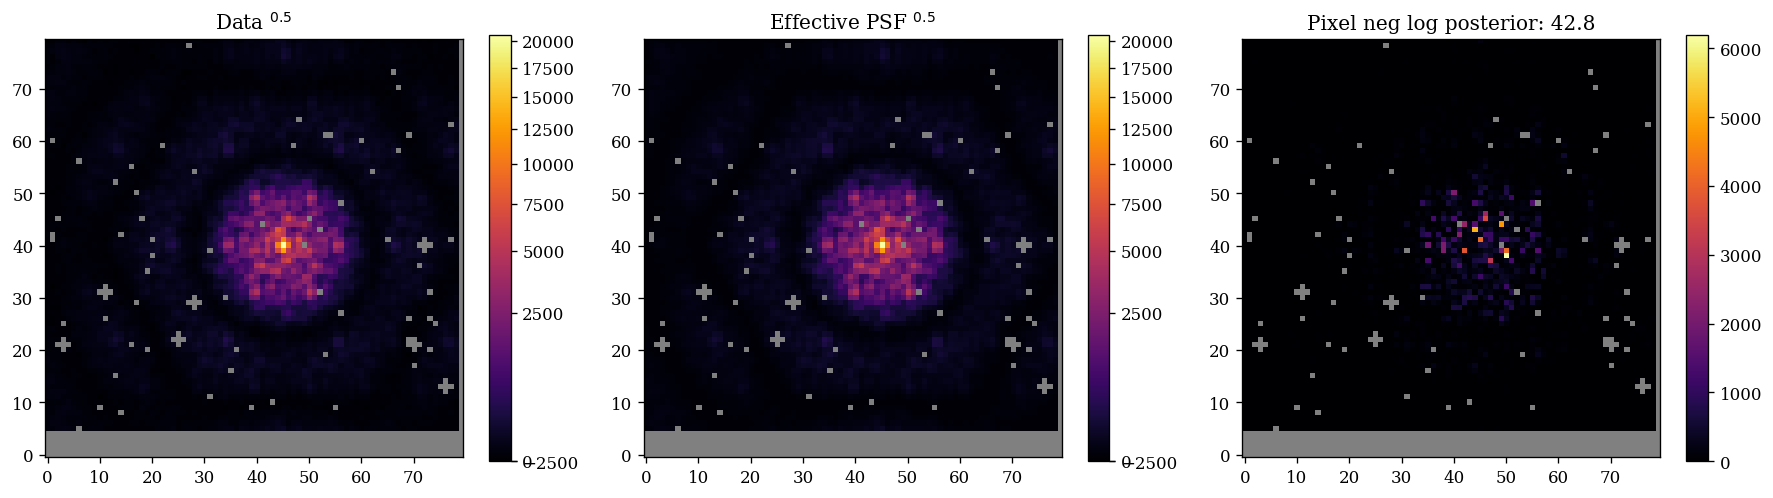

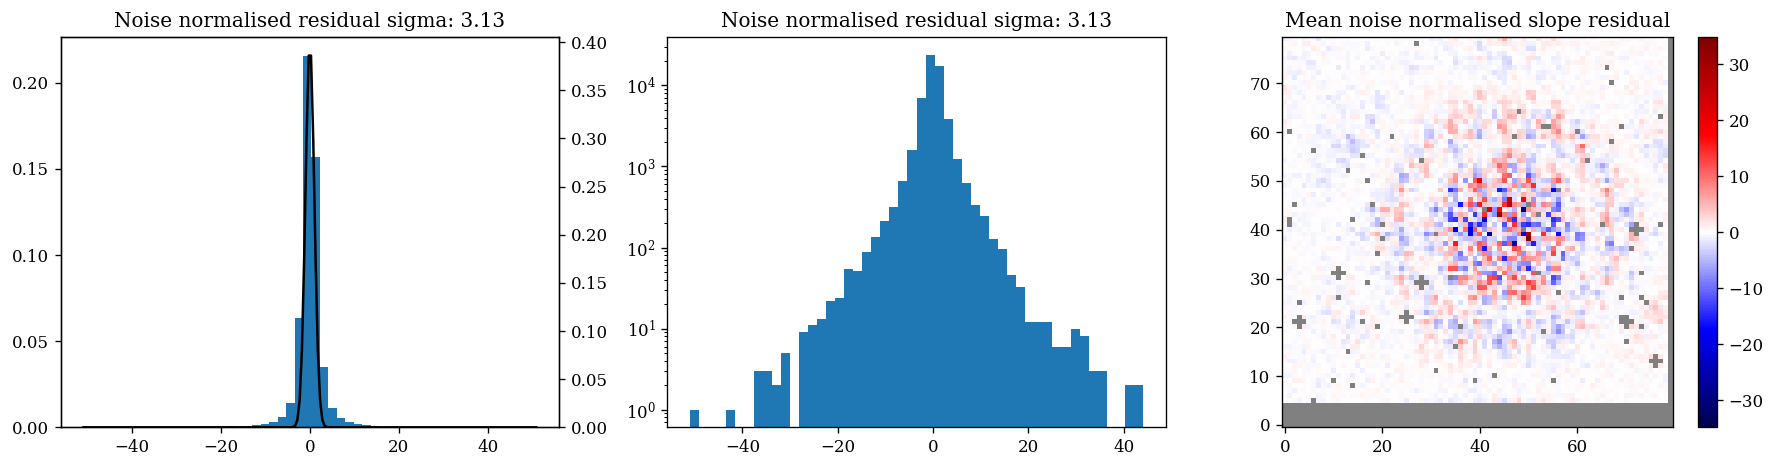

In [12]:
from amigo.plotting import summarise_fit

vis_fit = SplineVisFit(joint_fit=False)
exposures = get_exposures(files, vis_fit)

vis_model = SplineVis(model.optics)
model = model.set("visibilities", vis_model)

amplitudes = np.ones_like(vis_model.knots[0])
phases = np.zeros_like(vis_model.knots[0])

params = model.params
params["amplitudes"] = {}
params["phases"] = {}
for filt in ["F380M", "F430M", "F480M"]:
    params["amplitudes"][f"{exposures[0].key}"] = amplitudes
    params["phases"][f"{exposures[0].key}"] = phases
model = model.set("params", params)

summarise_fit(exposures[0], model, residuals=True, histograms=True)

## Test fisher calculation

In [13]:
from amigo.fisher import calc_fishers

params = [
    "amplitudes",
    "phases",
]
trained_EDM = model.ramp
model = model.set("ramp", None)
fishers = calc_fishers(model, exposures[:1], params, recalculate=True)
model = model.set("ramp", trained_EDM)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

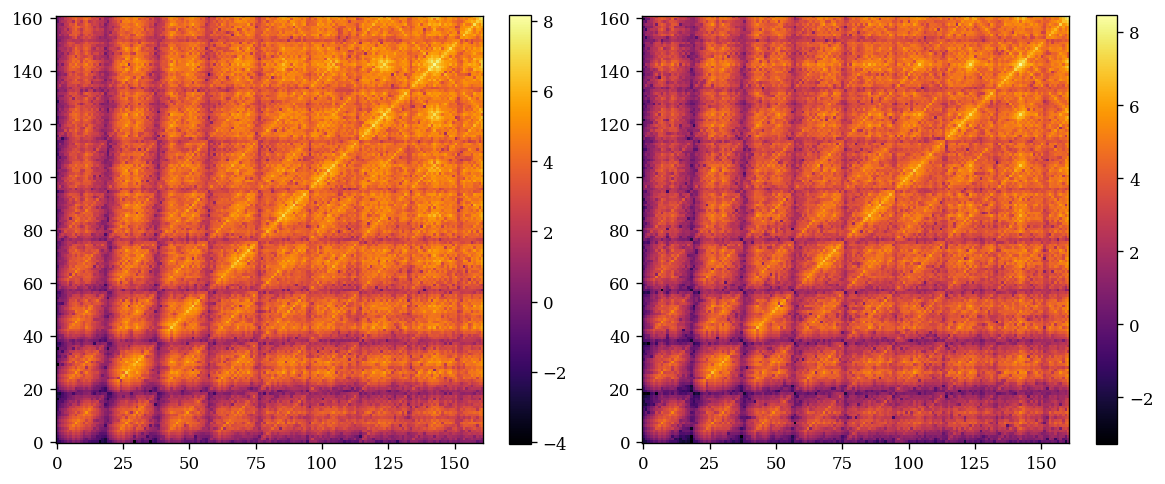

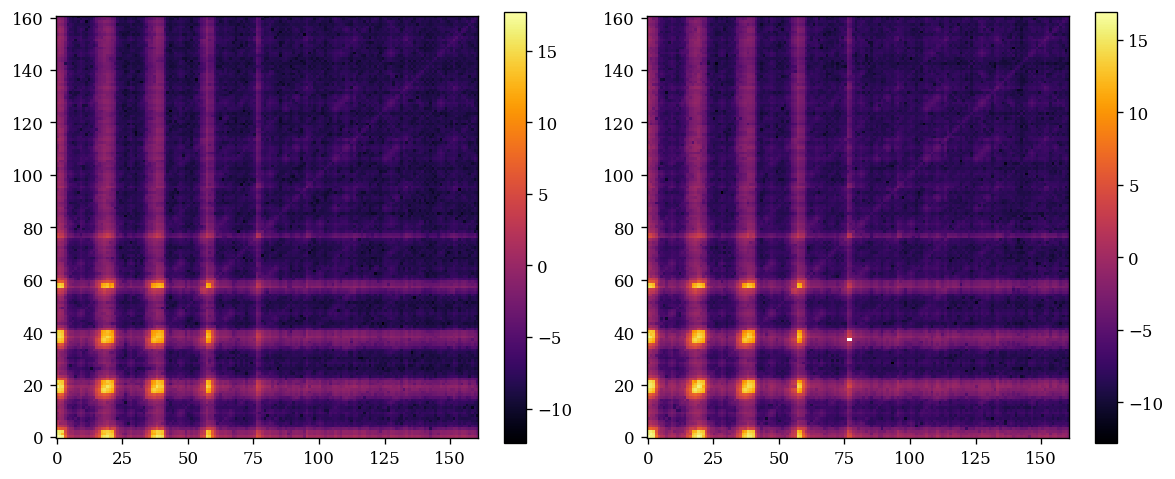

In [14]:
# Load the fisher, convert to per-pixel likelihood sum, get the contributing points
amp_fisher = 80**2 * fishers["04481_001_04_1"]['amplitudes'][:161, :161]
pha_fisher = 80**2 * fishers["04481_001_04_1"]['phases'][:161, :161]

amp_cov = -np.linalg.inv(amp_fisher)
pha_cov = -np.linalg.inv(pha_fisher)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.log10(np.abs(amp_fisher)))
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(np.log10(np.abs(pha_fisher)))
plt.colorbar()

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.log10(np.abs(amp_cov)))
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(np.log10(np.abs(pha_cov)))
plt.colorbar()

plt.tight_layout()
plt.show()

## Examine visibility uncertainty

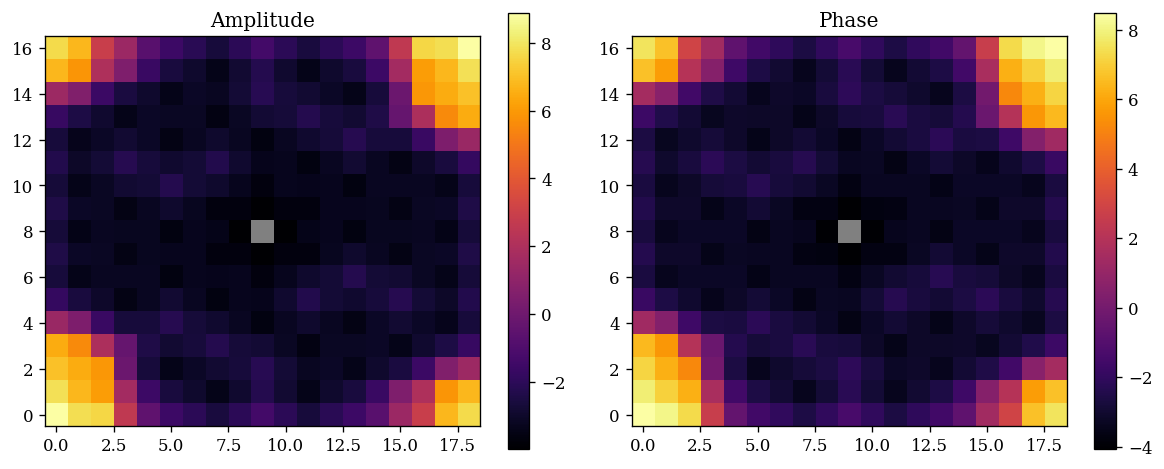

In [15]:
amp_fisher = fishers["04481_001_04_1"]["amplitudes"][:161, :161]
pha_fisher = fishers["04481_001_04_1"]["phases"][:161, :161]

amp_cov = -np.linalg.inv(amp_fisher * 80**2)
pha_cov = -np.linalg.inv(pha_fisher * 80**2)

amp_std_vec = np.diag(np.abs(amp_cov)) ** 0.5
pha_std_vec = np.diag(np.abs(pha_cov)) ** 0.5

amp_std = np.concatenate([amp_std_vec, np.array([0.0]), amp_std_vec[::-1]])
pha_std = np.concatenate([pha_std_vec, np.array([0.0]), pha_std_vec[::-1]])

amp_std = amp_std.reshape(vis_model.knots[0].shape)
pha_std = pha_std.reshape(vis_model.knots[0].shape)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Amplitude")
plt.imshow(np.log10(amp_std), inferno)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Phase")
plt.imshow(np.log10(pha_std), inferno)
plt.colorbar()

plt.tight_layout()
plt.show()

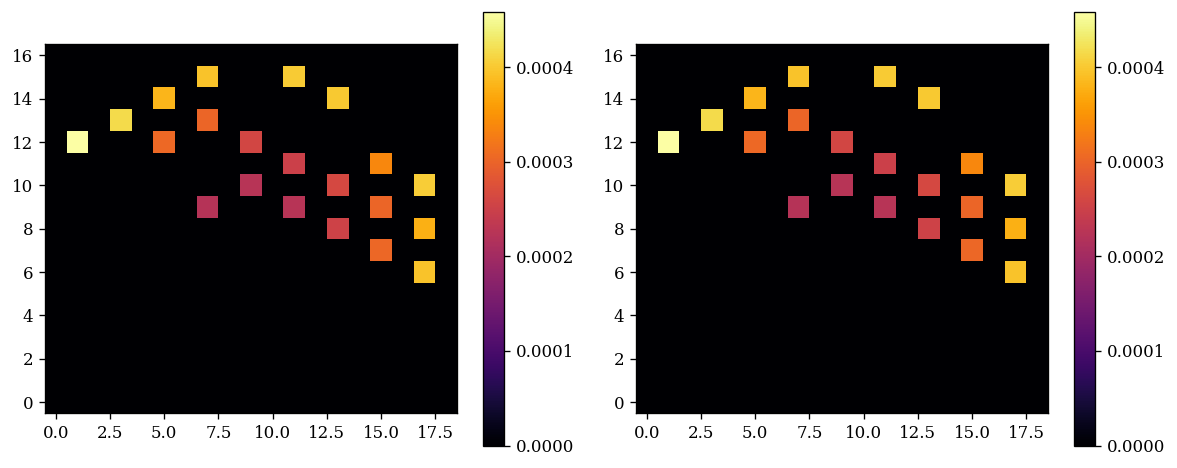

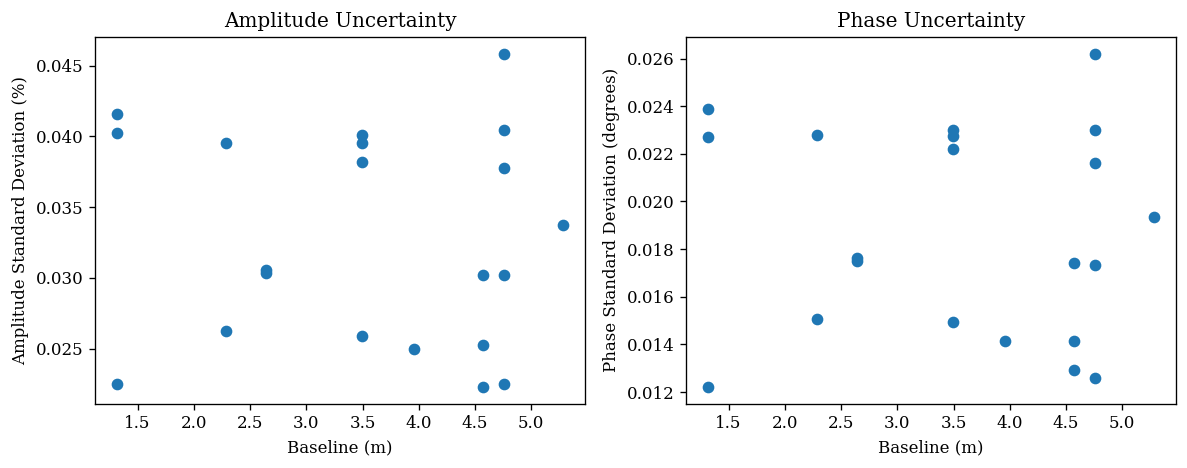

In [16]:
# # Make interpolator of the visibilities on the OTF coordinates
cen_holes = optics.holes - optics.holes.mean(0)[None, :]
hbls, inds = get_baselines_and_inds(cen_holes)
rs = np.hypot(hbls[:, 0], hbls[:, 1])

bls_pts = knots[:, *vis_model.bls_inds]
bls_map = np.sum(is_near.astype(int), 0)

amp_std = np.where(bls_map, amp_std, 0)
pha_std = np.where(bls_map, pha_std, 0)

amp_uncert = amp_std[*bls_inds]
pha_uncert = pha_std[*bls_inds]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(amp_std, inferno)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(amp_std, inferno)
plt.colorbar()

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Amplitude Uncertainty")
plt.xlabel("Baseline (m)")
plt.ylabel("Amplitude Standard Deviation (%)")
plt.scatter(rs, 100 * amp_uncert)

plt.subplot(1, 2, 2)
plt.title("Phase Uncertainty")
plt.xlabel("Baseline (m)")
plt.ylabel("Phase Standard Deviation (degrees)")
plt.scatter(rs, dlu.rad2deg(pha_uncert))

plt.tight_layout()
plt.show()